# Review: Complex Queries

* Restriction by a query (Subquery in the `WHERE` clause)
* Join
    - Cross join
    - Inner join
    - Equijoin
    - Natural join
* Aggregation  
    * `LEFT JOIN` followed by `GROUP BY`

# Relational Division

Relational division is a query of the type: 
> "Find all entries in A that have a mathcing entry in B for each entry in C."

For example, imagine you have a database for managing the hiring pipeline for a company. You have Tables `Candidate` and `CandidateSkill` listing all employees' skills. Then you have a table `Job` and `RequiredSkills`. 

You are now asked to
> "Show all the candidates who qualify for a given job."

Examples from other databases could be:
> "Find all students who have completed all the required courses for their major."
> "Find all students who have completed all the required courses for their major."
> "Show all airlins that every 

This is not a trivial query with no direct support in DataJoint and SQL. There are several ways to solve it. I will illustrate just one. You can search for other articles on relational division to review other approaches.

In [1]:
import datajoint as dj
from faker import Faker
fake = Faker()

In [2]:
schema = dj.Schema('dimitri_hiring')
schema.drop()
schema = dj.Schema('dimitri_hiring')

[2022-10-25 17:15:30,182][INFO]: Connecting dimitri@db.ust-data-sci.net:3306
[2022-10-25 17:15:30,790][INFO]: Connected dimitri@db.ust-data-sci.net:3306


Proceed to delete entire schema `dimitri_hiring`? [yes, No]: yes


In [3]:
@schema
class Skill(dj.Lookup):
    definition = """
    skill : varchar(24)
    """
    contents = zip(
        ("SQL", "Java", "Python", "C++", 
         "JavaScript", "R", "Rust"))

In [4]:
Skill()

skill
C++
Java
JavaScript
Python
R
Rust
SQL


In [5]:
@schema
class Candidate(dj.Manual):
    definition = """
    candidate_id : int
    ---
    name  : varchar(60)
    """
    
    class Skill(dj.Part):
        definition = """
        -> master
        -> Skill
        """

In [6]:
Candidate.insert(((fake.random_int(), fake.name()) for _ in range(300)), 
                 skip_duplicates=True)

In [7]:
Candidate()

candidate_id,name
23,Courtney Oneill
41,Tina Moss
42,Kenneth Terry
58,Ronald Roberts
143,Dennis Robertson
145,Jose Anderson
153,Lisa Atkins
180,Jade Clark
196,Jose Reynolds
200,Thomas Bolton


In [8]:
Candidate * Skill & 'rand() < 0.4'

candidate_id,skill,name
23,C++,Courtney Oneill
23,Java,Courtney Oneill
41,JavaScript,Tina Moss
41,SQL,Tina Moss
42,Java,Kenneth Terry
58,Java,Ronald Roberts
58,Python,Ronald Roberts
58,R,Ronald Roberts
143,Java,Dennis Robertson
143,JavaScript,Dennis Robertson


In [9]:
Candidate.Skill.insert(
    Candidate.proj() * Skill & 'RAND() < 0.4')

In [10]:
Candidate.Skill()

candidate_id,skill
23,C++
23,JavaScript
23,Python
23,SQL
41,C++
41,Java
41,JavaScript
41,R
41,Rust
42,C++


In [11]:
@schema
class Position(dj.Manual):
    definition = """
    position : varchar(12)   
    ---
    position_description : varchar(60)
    """

    class Skill(dj.Part):
        definition = """
        -> master
        -> Skill
        """

In [12]:
Position.insert1(("SWE1", "Software Engineer I"))
Position.Skill.insert((
    ("SWE1", "Rust"),
    ("SWE1", "JavaScript"),
    ("SWE1", "Java")))

In [13]:
Position.insert1(("DS2", "Data Scientist II"))
Position.Skill.insert((
    ("DS2", "SQL"),
    ("DS2", "Python")))

In [14]:
Position.Skill()

position,skill
DS2,Python
DS2,SQL
SWE1,Java
SWE1,JavaScript
SWE1,Rust


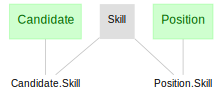

In [15]:
dj.Diagram(schema)

# Query example

In [16]:
Candidate & (Candidate.Skill() & 'skill = "Java"') \
& (Candidate.Skill() & 'skill = "Python"')

candidate_id,name
145,Jose Anderson
656,Jonathan Peterson
830,Tony Thompson
1239,Rebecca Hatfield
1567,Joseph Peters
1611,Joshua Swanson
2300,Glenda White
2462,Tamara Thomas MD
2692,Edward Johnston
3329,Max Williams


In [17]:
# All candidates who have the required skill

cpp_experts = Candidate & (Candidate.Skill & {"skill": 'C++'})
cpp_experts

candidate_id,name
23,Courtney Oneill
41,Tina Moss
42,Kenneth Terry
143,Dennis Robertson
145,Jose Anderson
200,Thomas Bolton
218,Bryce Smith
234,Jimmy Turner
281,Jordan Mccarthy
464,Dustin Thompson


### Show candidates who qualify for a given job

Rephrase (position)

> Show candidates who have *all* the skills required for job "SWE1"

Rephrasing (a double negative)

> Show candidates for whom there is no skill required for job "SWE1" that she does not possess.


In [18]:
# skills for SWE1
required_skill = Position.Skill() & {'position': "SWE1"}
required_skill

position,skill
SWE1,Java
SWE1,JavaScript
SWE1,Rust


In [19]:
Candidate - (Candidate().proj() * required_skill - Candidate.Skill())

candidate_id,name
41,Tina Moss
143,Dennis Robertson
1910,Peter Martinez
1918,Amanda Cox MD
2816,Bryan Bishop
2934,Tony May
3205,Troy Bailey
4034,Stephen Trujillo
4699,Andrew Cole
5000,Diana Day


In [20]:
Candidate.Skill()

candidate_id,skill
23,C++
23,JavaScript
23,Python
23,SQL
41,C++
41,Java
41,JavaScript
41,R
41,Rust
42,C++


In [21]:
# candidates' missing skills
missing_skill = Candidate.proj() * required_skill - Candidate.Skill
missing_skill

candidate_id,position,skill
23,SWE1,Java
23,SWE1,Rust
42,SWE1,JavaScript
42,SWE1,Rust
58,SWE1,Java
145,SWE1,JavaScript
145,SWE1,Rust
153,SWE1,Java
153,SWE1,Rust
180,SWE1,JavaScript


In [22]:
# qualified candidates
qualified_candidate = Candidate - missing_skill
qualified_candidate

candidate_id,name
41,Tina Moss
143,Dennis Robertson
1910,Peter Martinez
1918,Amanda Cox MD
2816,Bryan Bishop
2934,Tony May
3205,Troy Bailey
4034,Stephen Trujillo
4699,Andrew Cole
5000,Diana Day


In [23]:
# Candidates who qualify for job SWE1

Candidate - (
    (Candidate.proj() * Position.Skill & {'position': "SWE1"})
    - Candidate.Skill)

candidate_id,name
41,Tina Moss
143,Dennis Robertson
1910,Peter Martinez
1918,Amanda Cox MD
2816,Bryan Bishop
2934,Tony May
3205,Troy Bailey
4034,Stephen Trujillo
4699,Andrew Cole
5000,Diana Day


## SQL equlvalent

Literal translation of the above DataJoint query
```sql
USE dimitri_hiring;

SELECT candidate_id, name 
FROM candidate 
WHERE candidate_id NOT IN (
    SELECT candidate_id
    FROM candidate NATURAL JOIN position__skill
    WHERE position = "SWE1" AND (candidate_id, skill) NOT IN (
        SELECT candidate_id, skill FROM candidate__skill))
```

## Using Aggregation

Another method is to simply compare the number of matching skils for each candidate to the total number of matching skills, using aggregation.

In [24]:
Candidate()

candidate_id,name
23,Courtney Oneill
41,Tina Moss
42,Kenneth Terry
58,Ronald Roberts
143,Dennis Robertson
145,Jose Anderson
153,Lisa Atkins
180,Jade Clark
196,Jose Reynolds
200,Thomas Bolton


In [25]:
Candidate.Skill() * Position.Skill() & {'position': 'SWE1'}

candidate_id,skill,position
41,Java,SWE1
42,Java,SWE1
143,Java,SWE1
145,Java,SWE1
180,Java,SWE1
464,Java,SWE1
502,Java,SWE1
641,Java,SWE1
656,Java,SWE1
749,Java,SWE1


In [26]:
qualified = Candidate.aggr(
    Candidate.Skill * Position.Skill & {'position': "SWE1"}, 
     n='count(skill)') & 'n=3'

qualified

candidate_id,n calculated attribute
41,3
143,3
1910,3
1918,3
2816,3
2934,3
3205,3
4034,3
4699,3
5000,3


## SQL equivalent

```sql
SELECT candidate_id, name 
FROM candidate NATURAL JOIN 
     candidate__skill NATURAL JOIN position__skill
WHERE position="SWE1" 
GROUP BY candidate_id 
HAVING n=3
```

# Example from `sales`

In [29]:
sales = dj.create_virtual_module('sales', 'shared_sales')

## Show all Orders that contain the Products (1, 6, 11, 16, 36)

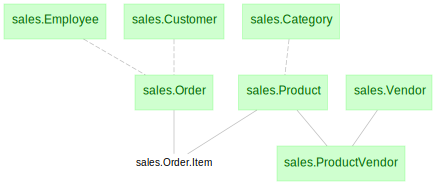

In [35]:
dj.Diagram(sales)

In [37]:
sales.Order & (sales.Order.Item & 'product_number in (1, 6, 11, 16, 36)')

order_number,order_date,ship_date,customer_id,employee_id
1,2017-09-02,2017-09-05,1018,707
3,2017-09-02,2017-09-05,1002,707
4,2017-09-02,2017-09-04,1009,703
5,2017-09-02,2017-09-02,1024,708
8,2017-09-02,2017-09-02,1003,703
10,2017-09-02,2017-09-05,1012,701
11,2017-09-03,2017-09-05,1020,706
13,2017-09-03,2017-09-03,1024,704
14,2017-09-03,2017-09-04,1013,704
15,2017-09-03,2017-09-07,1004,701


In [39]:
sales.Order.aggr(
    sales.Order.Item & 'product_number in (1, 6, 11, 16, 36)', n='count(*)') & 'n=5'

order_number,n calculated attribute
3,5
11,5
39,5
91,5
119,5
148,5
160,5
175,5
242,5
329,5


In [40]:
# Use the relational division pattern

desired_items = sales.Order.proj() * (sales.Product & 'product_number in (1, 6, 11, 16, 36)')

missing_items = desired_items - sales.Order.Item()

# orders that don't omit any of the desired items
sales.Order - missing_items

order_number,order_date,ship_date,customer_id,employee_id
3,2017-09-02,2017-09-05,1002,707
11,2017-09-03,2017-09-05,1020,706
39,2017-09-08,2017-09-11,1004,704
91,2017-09-15,2017-09-19,1010,703
119,2017-09-21,2017-09-21,1013,701
148,2017-09-27,2017-10-01,1027,704
160,2017-10-01,2017-10-01,1021,706
175,2017-10-05,2017-10-08,1013,706
242,2017-10-19,2017-10-21,1010,705
329,2017-11-04,2017-11-06,1004,708
